# Signal Processing

In this notebook we will explore methods for extracing signals from data.  This incldes computing correlation functions to tease out signals; convolution of data to model the impact of beams and for use as a filter; the use of the fourier transform for filtering and for signal extraction.

### Correlation Functions
    
The correlation fuction is defined as
$$C=⟨𝑓(𝑥′+𝑥)𝑔(𝑥′)⟩\tag{11}$$

which is actually the covariance from the previous notebook where $(x'+x) \rightarrow y$ and where the lag from $x'$ equals $x$.
 
Correlation functions are a way to measure the degree of similarity between a series and a lagged version of that same series, or even a another series. The former is an autocorrelation function, the latter is a cross-correlation.

<b> Warning: </b> for reasons I do not understand, many computational libraries conflate covariance and correlation. For instance, scipy.signal.correlate is equation 11. In order to meet the definition of correlation (at least [Pearson's definition of correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)), one needs to be careful on what to provide as input to scipy.signal.correlate. See our example below.




  
Autocorrelation (also called serial correlation) is: 
- the correlation of a function with itself but with a lag. 
- can be calculated by the Pearson’s correlation coefficient. 
- uses the same series twice - once in it’s original form and once in it’s lagged form.




### Example

We will use numpy's [corrcoef](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html), which returns an array of all possible correlations between two datasets. For example if <b>X</b> and <b>Y</b> are two arrays of data, the possible correlation coefficients which could be calcukated are $r_{XX}, r_{XY}, r_{YX}, r_{YY}$. Of course $r_{XX}$ and $r_{YY}$ are auto-correlations while $r_{XY}$ = $r_{YX}$ are cross-correlations.

We obtain tempoerature [data](https://www.wunderground.com) for a couple of months. We weill create arrays of daily temperatures which have a specified lag to them (i.e., one-day lag is x1=day 1-10; y1=day 2-11; two-day lag is y2=day 3-13....ten-day lag is x10=day 10-20; y10=day 20-30. We will apply numpy's "roll" function to make the task of creating lag vectors a bit easier. We can compare the results.

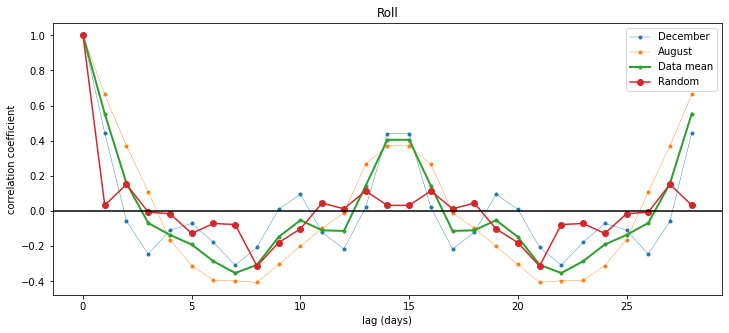

In [17]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#The data to examine
day = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
#Ann Arbor December 2021 temperature data from https://www.wunderground.com
dec_avg = [37.0,46.1,34.9,36.6,37.4,36.9,23.1,27.8,32.1,44.4,46.2,37.7,39.3,38.8,49.1,54.5,36.4,33.2,29.7,33.5,32.0,26.8,32.4,43.0,46.5,33.9,35.7,33.2,33.6]
aug_avg = [68.1,67.9,70.7,71.9,73.5,74.8,74.7,77.5,76.0,79.4,76.1,74.0,77.0,70.1,68.4,67.8,70.8,74.9,76.7,77.6,76.8,80.4,77.3,78.4,78.3,81.3,78.3,80.9,79.3]
#Place in arrays
day = np.array(day)
dec_avg = np.array(dec_avg)
aug_avg = np.array(aug_avg)

#Let's define a purely random series of tempersatures that has the same mean and spread of the data.
random1_avg = np.random.normal(np.mean(dec_avg), np.std(dec_avg), size = len(dec_avg))
random2_avg = np.random.normal(np.mean(aug_avg), np.std(aug_avg), size = len(aug_avg))

#Define max lag time (be careful with edges, maybe don't go beyond vector length*3) 

#We have two choices, NUMPYs "roll" or our own defined lag.
#Keep in mind that our max lag is 9 days (min lag is 0 days) unless we "roll over" the data
roll = True
if (roll):
    end = 29
else:
    end = 10
dec_corr = np.zeros((end,end))
aug_corr = np.zeros((end,end))
random1_corr = np.zeros((end,end))
random2_corr = np.zeros((end,end))
lag = np.arange(0,end,1)

for j in range(end):
    for i in range (end):
        #First, we calculate December's correlation function
        if (roll):
            avg_day = dec_avg
            avg_lag = np.roll(dec_avg,i)      
        else:
            avg_day = dec_avg[j:j+end]
            avg_lag = dec_avg[j+i:j+i+end]
        dec_corr[j,i] = np.corrcoef(avg_day,avg_lag)[1,0]
#       or we could use r_xy = (np.mean((avg_day - np.mean(avg_day))*(avg_lag - np.mean(avg_lag))))/(np.sqrt(np.var(avg_day)*np.var(avg_lag)))    

        #Second, we calculate August's correlation function
        if (roll):
            avg_day = aug_avg
            avg_lag = np.roll(aug_avg,i)      
        else:
            avg_day = aug_avg[j:j+end]
            avg_lag = aug_avg[j+i:j+i+end]
        aug_corr[j,i] = np.corrcoef(avg_day,avg_lag)[1,0]  

        #Third, we calculate the random1 (Decemeber) data correlation function
        if (roll):
            avg_day = random1_avg
            avg_lag = np.roll(random1_avg,i)      
        else:
            avg_day = random1_avg[j:j+end]
            avg_lag = random1_avg[j+i:j+i+end]
        random1_corr[j,i] = np.corrcoef(avg_day,avg_lag)[1,0]  
        #Fourth, we calculate the random2 (August) data correlation function
        if (roll):
            avg_day = random2_avg
            avg_lag = np.roll(random2_avg,i)      
        else:
            avg_day = random2_avg[j:j+end]
            avg_lag = random2_avg[j+i:j+i+end]
        random2_corr[j,i] = np.corrcoef(avg_day,avg_lag)[1,0]  

dec_mean_r = np.mean(dec_corr,axis=0)
aug_mean_r = np.mean(aug_corr,axis=0)
data_mean_r = (dec_mean_r + aug_mean_r)/2
random1_mean_r = np.mean(random1_corr,axis=0)
random2_mean_r = np.mean(random2_corr,axis=0)
random_mean_r = (random1_mean_r + random2_mean_r)/2.0

###############################

#Now, make the plot
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,1,1)  

ax1.plot(lag,dec_mean_r,'.-',linewidth=0.4, label='December')
ax1.plot(lag,aug_mean_r ,'.-',linewidth=0.4,label='August')
ax1.plot(lag,data_mean_r ,'.-',linewidth=2,label='Data mean')

ax1.plot(lag,random_mean_r,'o-',label='Random')
ax1.axhline(0,color='black')
ax1.set_xlabel('lag (days)')
ax1.set_ylabel('correlation coefficient')
ax1.legend()
if (roll):
    ax1.set_title('Roll')
else:
    ax1.set_title('Lag vectors')
plt.show()




### discuss: 
    What's happening at t=14 or t =15 days or t=30 days?
    

## alternative implementation

We will use scipy.signal library and the correlate function. We also need the lags given by correlation_lags (instead of calculating our own). <b> The function signal.correlation_lags is only available in scipy 1.6+</b>

<b>NOTE:</b> scipy.signal.correlate does not naturally return the equivalent of the Pearson correlation (see above). In order to do so, one must use the centered data and also normalize the input to the standard deviation.


1.7.1


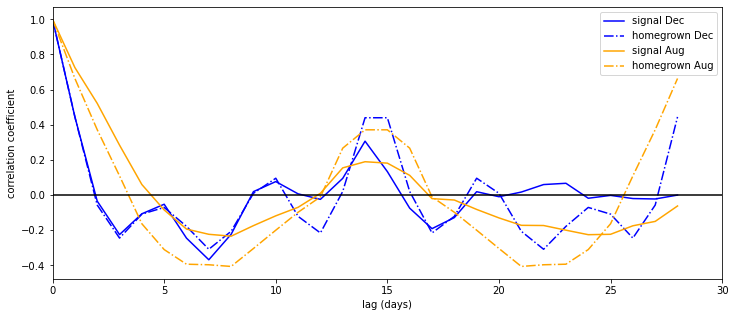

In [15]:
##You must have version scipy.signal >=1.7 to use correlation_lags
import scipy
print(scipy.__version__)
import scipy.signal as signal

dec_corr2 = signal.correlate((dec_avg - np.mean(dec_avg))/np.std(dec_avg),(dec_avg - np.mean(dec_avg))/np.std(dec_avg),mode='full',method='direct')/len(dec_avg)
dec_lag2 = signal.correlation_lags(dec_avg.size,dec_avg.size,mode='full')
aug_corr2 = signal.correlate((aug_avg - np.mean(aug_avg))/np.std(aug_avg),(aug_avg - np.mean(aug_avg))/np.std(aug_avg),mode='full',method='direct')/len(aug_avg)
aug_lag2 = signal.correlation_lags(aug_avg.size,aug_avg.size,mode='full')

#Now make the plot
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,1,1)  
ax1.plot(dec_lag2,dec_corr2,'b',label='signal Dec')
ax1.plot(lag,np.mean(dec_corr,axis=0),'b',linestyle='-.',label='homegrown Dec') 
ax1.plot(aug_lag2,aug_corr2,'orange',label='signal Aug')
ax1.plot(lag,np.mean(aug_corr,axis=0),'orange',linestyle='-.',label='homegrown Aug') 
ax1.axhline(0,color='black')
ax1.set_xlabel('lag (days)')
ax1.set_ylabel('correlation coefficient')
ax1.set_xlim(0,30)#NOTE THE LIMIT OF 0. What happens if I DROP THIS?
ax1.legend()
plt.show()

Note that both calculates are close to each other, but not identical. When in doubt and when you want a correlation coefficient (function), use np.corrcoef.

While it does make things less cumbersome, you still need to be careful about your interpretation of the resultes.

For instance, I plotted only for lags >0. If you remove that, you will see the mirror image appear:

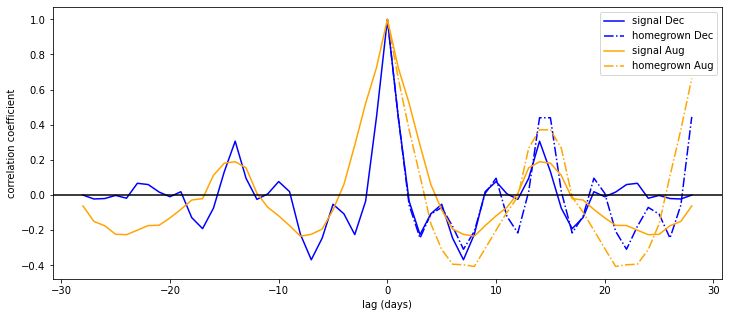

In [16]:
#Now make the plot
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,1,1)  
ax1.plot(dec_lag2,dec_corr2,'b',label='signal Dec')
ax1.plot(lag,np.mean(dec_corr,axis=0),'b',linestyle='-.',label='homegrown Dec') 
ax1.plot(aug_lag2,aug_corr2,'orange',label='signal Aug')
ax1.plot(lag,np.mean(aug_corr,axis=0),'orange',linestyle='-.',label='homegrown Aug') 
ax1.axhline(0,color='black')
ax1.set_xlabel('lag (days)')
ax1.set_ylabel('correlation coefficient')
ax1.legend()
plt.show()

####  Some lessons
    - Covariance and correlation are often confusing conflated in the literature
    - for instance, if the data have unit variance (i.e. a scaled Gaussian), correlation is exactly covariance
    - sometimes texts/authors will assume the variance can just be scaled out and write their theory accordingly
    - you don't always know that or understand the consequences of a throw-away comment in their text
    - Calculating covariance is straightforward, but occasionally there can be numerical issues (see Wikipedia for examples)
    - There is no "right" way to calculate correlation (see above where we tried 3(!) techniques) and they do not always agree. 
    - The 2-pt spatial correlation function is calculated through "pair counting" within spheres of radius $R$ --the lag. Counts are made in the data and compared to randomly distributed points. This looks NOTHING like the tools we have used above which are common in 1D signal processing.
    - The coin example is another case where we have "made up" our measure of correlaton.
 
   
#### Final thought on Correlation
    
When discussing signal processing, you will often see correlation expressed as a continuous integral:

$$(f \otimes g)(\tau) = \int_{-\infty}^\infty f^*(t) g(t + \tau) dt  \tag{12}$$

where $f$ and $g$ are signals at given times $t$ with some lag $\tau$. If the signal is light (or anything that could be represented as a complex number), then we require the complex conjugate of $f$ in the integrand (shown as $f^*$.



## 3. Convolution

Imagine you manage a hospital treating patients with a single disease. 

You have:

- A treatment plan: [3] Every patient gets 5 units of the cure on their first day.
- A list of patient counts per day of the week: [1 2 3 4 5]

How much medicine do you use each day? 

5 $\times$  [ 1 2 3 4 5] = [5 10 15 20 25] units....easy.

You change to a more realistic treatment plan: 
- A treatment plan: [5 3 1] Every patient gets 5 units of the cure on their first day, 3 their second, 1 their third.

We can do this, but it gets harder. 

The trick is to flip the treatment plan to [1 3 5]  and walk the treatment schedule backwards through the patients. Here's the view:

Monday

    1  3  5                  
          *
         [1  2  3  4  5] 
    
         =5           
            
Tuesday

      1  3  5       
         *  *
        [1  2  3  4  5]
    
         3 +10 = 13
              

Wednesday
 
          1  3  5 
          *  *  *
         [1  2  3  4  5]
    
          1 + 6 + 15 = 22
             
Thursday

             1  3  5
             *  *  *
         [1  2  3  4  5]
    
             2+ 9 +20 = 31
        
Friday

                1  3  5
                *  *  *
         [1  2  3  4  5]
       
                3 +12+25 = 40            

And we have to finish the treatments of the patients who came in later in the week:

Saturday

                   1  3  5
                   *  *
         [1  2  3  4  5]
    
                   4 + 15 = 19
      
Sunday

                      1  3  5
                      *
         [1  2  3  4  5]
    
                      = 5

Which leaves us with the following requirements for our treatment units:
[5 13 22 31 40 19 5]

This calculation is the convolution of the plan and patient counrs.


### the definition
When discussing signal processing, you will often see convolution expressed as:

$$(f \star g)(\tau) = \int_{-\infty}^\infty f(t) g(\tau -t) dt \tag{13}$$
$$(g \star f)(\tau) = \int_{-\infty}^\infty f(\tau -t) g(t) dt$$

Note the new symbol $\star$ representing the operation and note that one of functions is <i> reversed </i>. We speak of $f$ being the source and $g$ being the filter of the convolution.


### properties 
Some useful properties of the convolution include:

- It is commutative
- It integrates as seperable functions: $$\int f \star g = \int f \int g$$
- $\displaystyle{f(t) * \delta(t) = f(t)}$
- $\displaystyle{f(t) * \delta(t - T) = f(t - T)}$


### example

The <a href="https://en.wikipedia.org/wiki/Convolution">convolution</a> of two discretely sampled (with $N$ samples) functions $f_i$ and $g_i$ is defined as $$(f * g)_k = \sum_{i=0}^{N-1} f_k g_{i-k} \tag{12}$$.

In other words, to calcuate the convolution: (1) multiply two functions and sum them to get a number and (2) repeat the procedure for all possible offsets.

We next compute the convolution of a gaussian or $\chi^2$ with two delta functions using equation 12:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def convolution(f,g):
    g=g[::-1]
    N = np.size(f)
    conv = np.zeros(N)
    i = 0
    while (i <N):
        conv[i] = np.sum(f *np.roll(g,i))
        i+=1
    return(conv)


In [6]:
#Import a chi2 library from stats
from scipy.stats import chi2
N = 512
t = np.arange(1,N+1)/N ## n/N becomes time, a variable from 0 to 1. Note that it is COMPLEX


#Create the two delta functions over the 1024 space used earlier.
f = np.zeros(N)
f[int(N*1/6)] = 1.
f[int(N*5/6)] = 1.


## create a function to convolve with our delta funcitons.
gauss=True

if chi2:    
    g = chi2.pdf(np.real(t), 55)
    g = g/np.max(g)
if gauss:
    g = np.exp(-5 * ((t-np.mean(t))/.1)**2.)

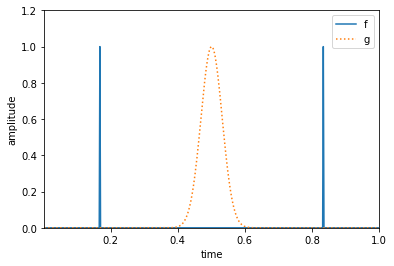

In [8]:
#run the convolution
conv = convolution(f,g)
#plot the results
plt.plot(t,f, label='f')
plt.plot(t,g, ':', label='g')
#plt.plot(t,conv,"r", label='convolution')
plt.legend(loc='best')
plt.axis([np.min(t),np.max(t),0,1.2])

plt.xlabel("time")
plt.ylabel("amplitude")
#pl.title("f (blue), g(green), and the convolution of these (red)")
plt.show()

Notice that the convolved delta functions are not at the correct location. This is because the lag ($\tau$ in the formula or $i$ in the code) walks forward from where it starts (see above example). So our lags have a <i> shift </i> that we must account for, which in this case is N/2 What's tne solution? We <i>roll</i> $t$ forward by this amount:

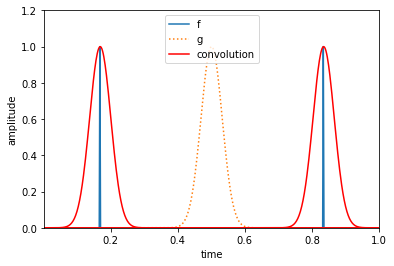

In [11]:
#run the convolution
conv = convolution(f,g)
#plot the results
plt.plot(t,f, label='f')
plt.plot(t,g, ':', label='g')
plt.plot(np.roll(t,int(N/2)),conv,"r", label='convolution')
plt.legend(loc='best')
plt.axis([np.min(t),np.max(t),0,1.2])

plt.xlabel("time")
plt.ylabel("amplitude")
#pl.title("f (blue), g(green), and the convolution of these (red)")
plt.show()

We can also just remove this shift if we change our "filter" ($g(t)$) to be centered on the origin. In many cases, it is best to just keep things centered at the origin if possible, especially the filter inside a convolution.

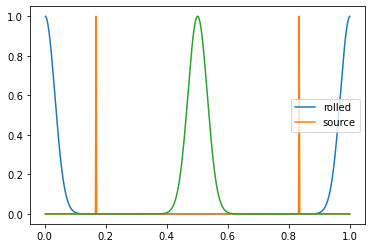

In [12]:
plt.plot(t,(np.roll(g,int(N/2))),label='rolled')
plt.plot(t,f, label='source')
plt.legend()
plt.plot(t,g)

In [12]:
# Roll the function g by the Nyquist frequency to shift it
conv_shift = convolution(f,np.roll(g,int(N/2)))

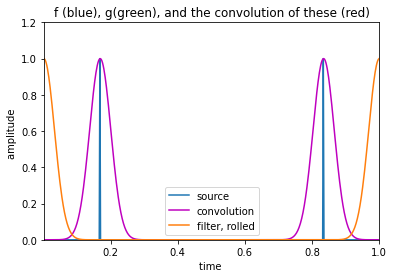

In [13]:
#plot it
plt.plot(t,f, label='source')
plt.plot(t,conv_shift,"m", label='convolution')
plt.plot(t,np.roll(g,int(N/2)),label='filter, rolled')
plt.legend(loc='best')
plt.axis([np.min(t),np.max(t),0,1.2])

plt.xlabel("time ")
plt.ylabel("amplitude ")
plt.title("f (blue), g(green), and the convolution of these (red)")
plt.show()

## 4. Fourier series 

- The Fourier Series is the circle & wave-equivalent for estimating a function like one does with a [Taylor Series](https://en.wikipedia.org/wiki/Taylor_series). 

- The Fourier Series breaks down any periodic function into a simple series of sine & cosine waves.

- The Fourier Series a key underpinning to any & all digital signal processing

- a Fourier Series cannot be applied to general functions — it can only converge to periodic functions

### Example
We want to approximate a periodic function f(x), with fundamental period T, with a Fourier series. 

Suppose our function $f(x)$ looks like this (note that we will carefully and explicitly make it periodic):

512


/var/folders/83/7nsbm0g94n7ctgnm_6rvxll40000gn/T/ipykernel_1382/2132126411.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.append(y, np.piecewise(x[i], [(np.int(x[i])%2) != 0 < 0, (np.int(x[i])%2) == 0], [-1, 1]))
/var/folders/83/7nsbm0g94n7ctgnm_6rvxll40000gn/T/ipykernel_1382/2132126411.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int3

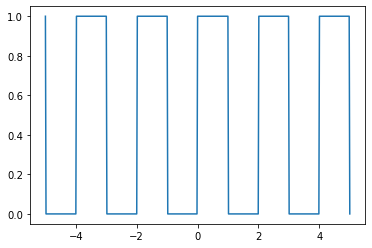

In [13]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(0,5,257)
y = []
for i in range(len(x)):
    y = np.append(y, np.piecewise(x[i], [(np.int(x[i])%2) != 0 < 0, (np.int(x[i])%2) == 0], [-1, 1]))
x2 = np.linspace(-5,0,256)
y2 = []
for i in range(len(x2)):
    y2 = np.append(y2, np.piecewise(x2[i], [(np.int(x2[i])%2) == 0 < 0, (np.int(x2[i])%2) != 0], [-1, 1]))
xvec = np.append(x2[0:len(x2)-1],x) #We stop x2 JUST BEFORE it hits zero, since x starts with zero.
yvec = np.append(y2[0:len(y2)-1],y)
plt.plot(xvec,yvec)
print(len(xvec))
fx = yvec

$$g(x) = \displaystyle\sum_{n=0}^{?} \{a_n cos(n\times x) + b_n sin(n\times x)\} \tag{16}$$

where $g(x)$ is the approximation of the function $f(x)$. 

Summing a series to $\infty$ is problematic. Limits can sometimes be applied, but computers do not work to $\infty$.

Notice that we can re-write equation (16) as:

$g(x) = {a_0} + \displaystyle\sum_{n=1}^{?} \{a_n cos(n\times x) + b_n sin(n\times x)\}$  

Notice that $g(x)$ is a constant and a series of sines and cosines, with $b_0 =0$.

###### Periodicity implies constraints on what $n\times x$ can be. How do we rewrite eq 1 to reflect this?


$g(x) = a_0 + \displaystyle\sum_{n=1}^{?} \{a_n cos(\frac{2\pi n}{P}\times x) + b_n sin(\frac{2\pi n}{P}\times x)\}$

where $P$ here is the period of the repeatibility of the function. 

###### When does the series stop?

$$g_{M,N}(x) = {a_0} + \displaystyle\sum_{m=1}^{M} a_m cos(\frac{2\pi m}{P}\times x) + \displaystyle\sum_{n=1}^{N} b_n sin(\frac{2\pi n}{P}\times x) \tag{17}$$


for now, we stop at M and N, but we need to decide this later.....

##### What do the terms means and how do we solve for them?

The first term in equation 17 is just the average value of $f(x)$. The series is then constructed to provide the right amount (and sign) of variations around this average to $f(x)$.

So we just use equation 3 (the arithmetic mean) to explain $a_0$:

$$
a_0 = \frac{1}{P}\displaystyle\int_{0}^{P} f(t) dt 
$$

So what is $a_0$ for our function which has a period $P=2$?
